<a href="https://colab.research.google.com/github/Minaa96/PPPO/blob/main/Klasifikacija_pasa_Mina_Lazic_IT81_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prvo je bilo potrebno instalirati novu verziju gdown-a, jer nije hteo da otvori link.



In [ ]:
pip install --upgrade --no-cache-dir gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


**IMPORTI**

Definisanje neophodnih biblioteka za dalji rad

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl/view

Downloading...
From: https://drive.google.com/uc?id=16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl
To: /content/#6.zip
100% 724M/724M [00:24<00:00, 29.5MB/s]


In [ ]:
!unzip "/content/#6.zip" -d "/content/unzipped"


Streaming output truncated to the last 5000 lines.
  inflating: /content/unzipped/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: /content/unzipped/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /content/unzipped/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /content/unzipped/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /content/unzipped/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /content/unzipped/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /content/unzipped/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /content/unzipped/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /content/unzipped/train/83fad0718581a696132c96c166472627.jpg  
  inflating: /content/unzipped/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: /content/unzipped/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: /content/unzipped/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: /content/unzipped/train/

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import cv2

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import load_img

<ipython-input-11-c0a522880d82>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [ ]:
train_dir = '/content/unzipped/train'
test_dir = '/content/unzipped/test'

data_size = get_num_files(train_dir)
test_size = get_num_files(test_dir)
print('Data samples size: ', data_size)
print('Test samples size: ', test_size)

Data samples size:  10222
Test samples size:  10357


In [ ]:
labels_dataframe = pd.read_csv('/content/unzipped/labels.csv')

sample_df = pd.read_csv('/content/unzipped/sample_submission.csv')

labels_dataframe.head(15)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


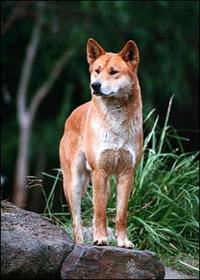

In [ ]:
path = "/content/unzipped/train/00a338a92e4e7bf543340dc849230e75.jpg"
img = cv2.imread(path)
cv2_imshow(img)

In [ ]:
unique_breeds = labels_dataframe["breed"].value_counts()
print(unique_breeds)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


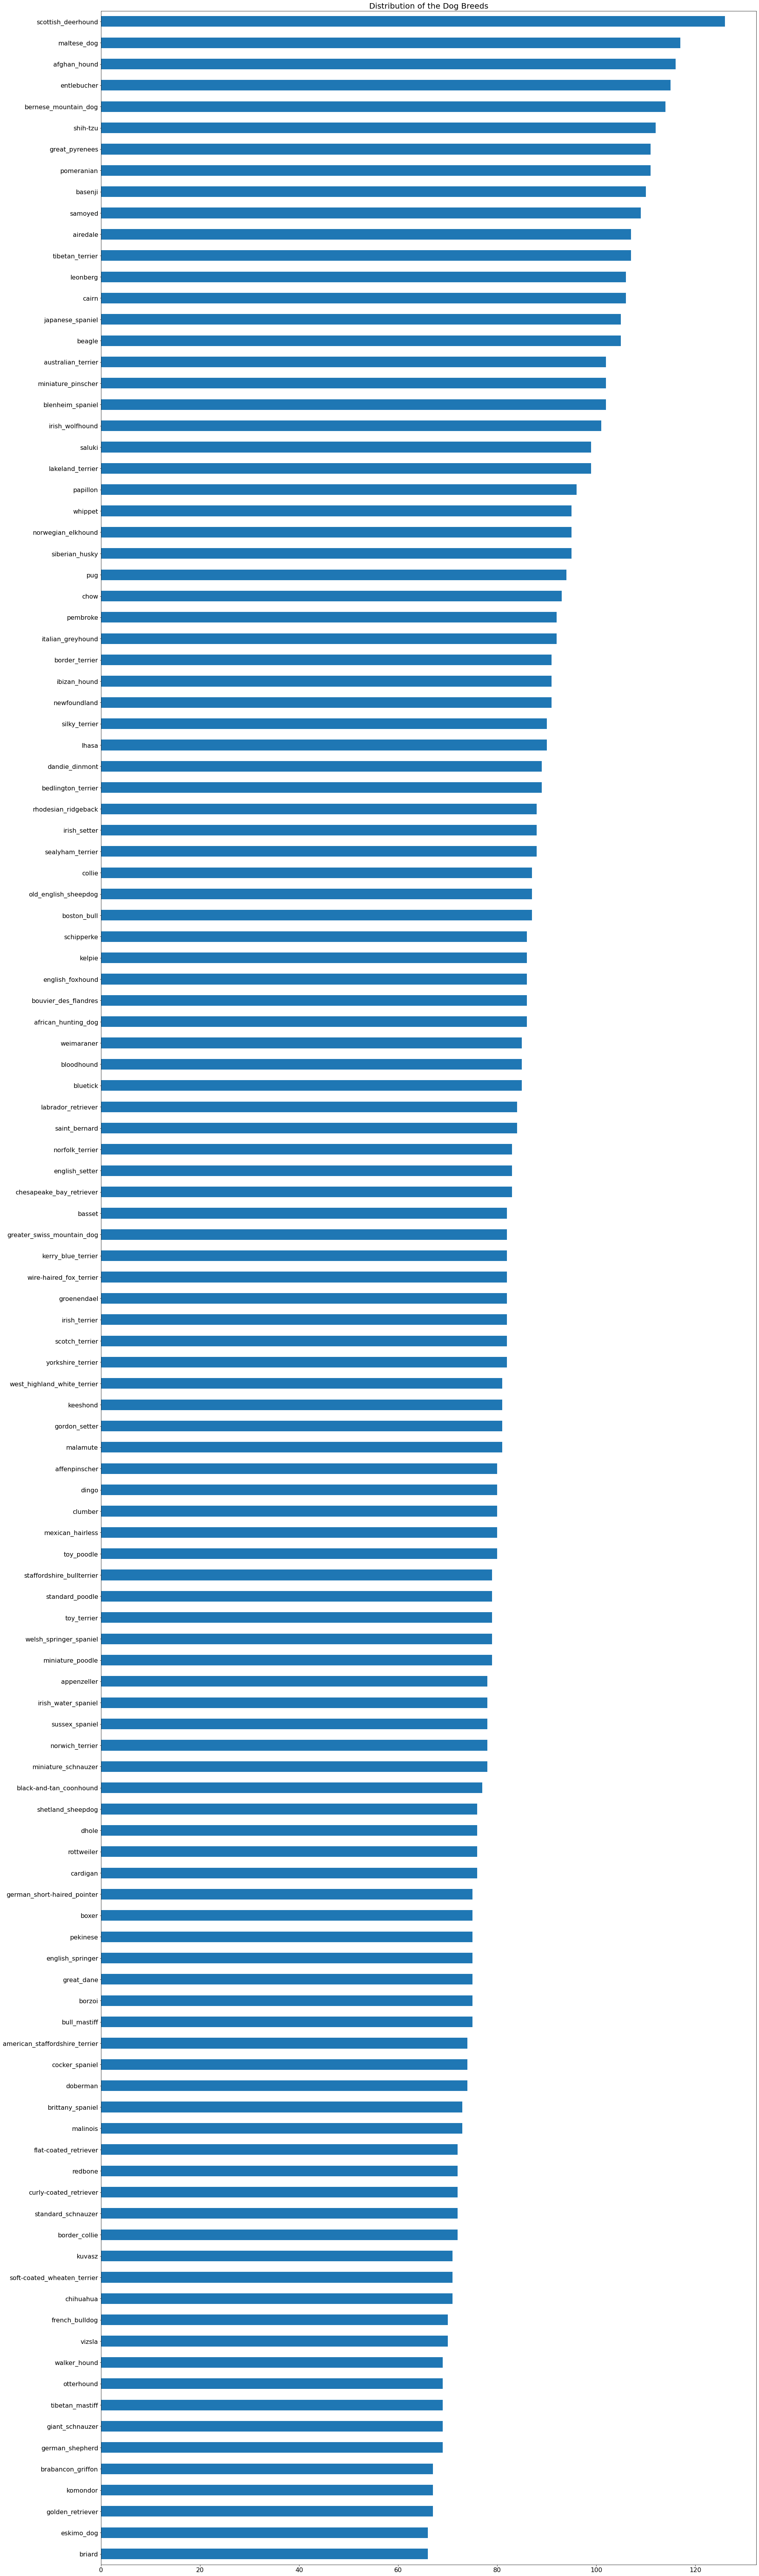

In [ ]:
bar = labels_dataframe["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

In [ ]:
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']